# Analysis of Mushroom Attributes
Author: Crystal Tran

Course Project, UC Irvine, Math 10, S24

I would like to post my notebook on the course’s website. [Yes]

## **Introduction**

The ultimate goal of this analysis is to classify mushrooms as edible or poisonous given select features of the [mushroom dataset](https://www.kaggle.com/datasets/vishalpnaik/mushroom-classification-edible-or-poisonous/data). We will use feature selection, data scaling, data balancing, and cross-validation on different regression and classification models in order to create the best model to classify mushrooms. 

Additionally, we will explore the data to possibly determine other interesting correlations between the selected features.

## **Import**

In [807]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn import metrics
from sklearn.utils import resample

## **Data Cleaning**

The dataset has a total of **20** features in addition to mushroom class, but for simplicity, we will only use about half of those features. The features that we select will be features that are easily determined by examining the mushroom, such as the shape, surface, and color of the mushroom, as well as features that can be measured, such as cap diameter and stem dimensions.

In [808]:
df = pd.read_csv("mushroom.csv")
df.drop(["gill-spacing", "spore-print-color", "stem-root", "veil-type", "veil-color", "habitat", "gill-attachment", "gill-color", "season", "ring-type"], axis=1, inplace=True)
df.dropna()
df.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,stem-height,stem-width,stem-surface,stem-color,has-ring
0,p,15.26,x,g,o,f,16.95,17.09,y,w,t
1,p,16.60,x,g,o,f,17.99,18.19,y,w,t
2,p,14.07,x,g,o,f,17.80,17.74,y,w,t
3,p,14.17,f,h,e,f,15.77,15.98,y,w,t
4,p,14.64,x,h,o,f,16.53,17.20,y,w,t


## **Data Preprocessing**

In order to get the data ready for analysis, we will change all boolean values to 0 or 1 as well as changing data with string values to dummy features.

In [809]:
isPoisonous = {"p": 1, "e": 0}
boolean = {"t": 1, "f": 0}
df = df.replace({"class": isPoisonous, "has-ring": boolean, "does-bruise-or-bleed": boolean})

dummy_features = ["cap-shape", "cap-surface", "cap-color", "stem-surface", "stem-color"]
df_dummies = pd.get_dummies(df[dummy_features], drop_first=True)
df_dummies = df_dummies.replace({i: {True: 1, False: 0} for i in df_dummies.columns.tolist()})
df = df.join(df_dummies)
df.drop(dummy_features, axis=1, inplace=True)
df.head()

,class,cap-diameter,does-bruise-or-bleed,stem-height,stem-width,has-ring,cap-shape_c,cap-shape_f,cap-shape_o,cap-shape_p,...,stem-color_g,stem-color_k,stem-color_l,stem-color_n,stem-color_o,stem-color_p,stem-color_r,stem-color_u,stem-color_w,stem-color_y
0,1,15.26,0,16.95,17.09,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,16.60,0,17.99,18.19,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,14.07,0,17.80,17.74,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1,14.17,0,15.77,15.98,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,14.64,0,16.53,17.20,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


Now we can to feed the data into classification models to predict mushroom class given the features.

## **Classification Models**

### Data Balancing

From the distribution of mushroom class, we can see that there is about 11% more poisonous mushrooms in our dataset than edible mushrooms. We will simply oversample the edible mushroom class to balance the dataset. Additionally, we will also use balanced class weights for each model to ensure that the model performs most accurately.

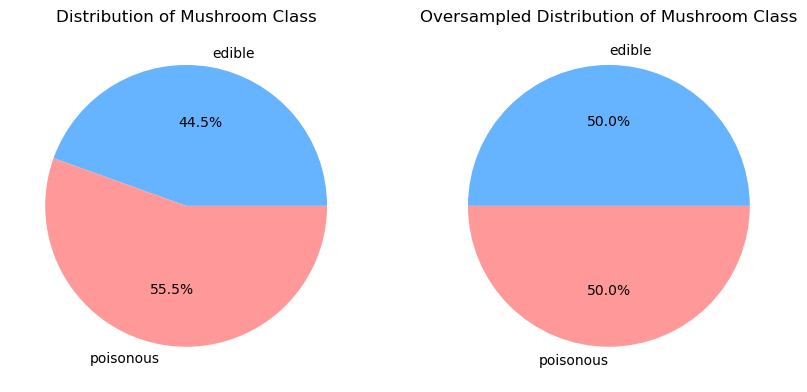

In [810]:
fig, ax = plt.subplots(1, 2, figsize=(10, 15))

count_class = {0: 0, 1: 0}
for i in df["class"]:
    count_class[i] += 1
    
ax[0].pie([count_class[i] for i in count_class], labels=['edible', 'poisonous'], autopct='%1.1f%%', colors=['#66b3ff','#ff9999'])
ax[0].set_title('Distribution of Mushroom Class')

df_poisonous = df[df["class"] == 1]
df_edible = df[df["class"] == 0]

edible_group_oversampled = resample(df_edible, replace=True, n_samples=len(df_poisonous.index), random_state=0)
df = pd.concat([edible_group_oversampled, df_poisonous])
df = df.reset_index(drop=True)

count_class = {0: 0, 1: 0}
for i in df["class"]:
    count_class[i] += 1

ax[1].pie([count_class[i] for i in count_class], labels=['edible', 'poisonous'], autopct='%1.1f%%', colors=['#66b3ff','#ff9999'])
ax[1].set_title('Oversampled Distribution of Mushroom Class')
plt.show()

### Training and Testing Sets

In [811]:
features = df.columns.tolist()
features.pop(0)
target = "class"

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=True, random_state=1)

### Logistic Regression Model

In [812]:
log_reg = LogisticRegression(max_iter=1000, class_weight="balanced")
log_reg.fit(X_train, y_train)

print(f"Accuracy for Logistic Regression: {log_reg.score(X_test, y_test):.4f}")

Accuracy for Logistic Regression: 0.7305


### KNN Classification Model

We can to determine the best value of k and fit the KNN classification model.

In [813]:
best_k = 0
best_accuracy = 0

for k in range(1, 6):
    knn = KNeighborsClassifier(n_neighbors=k, weights="distance")
    
    knn.fit(X_train, y_train)
    accuracy = knn.score(X_test, y_test)
    
    print(f'k = {k}: {accuracy:.4f}')
    
    if accuracy > best_accuracy:
        best_k = k
        best_accuracy = accuracy
        
print()        
print(f"Best k is k = {best_k} with an accuracy of {best_accuracy:.4f}.")

knn = KNeighborsClassifier(n_neighbors=best_k, weights="distance")
knn.fit(X_train, y_train)

print()
print(f"Accuracy for KNN Classification: {knn.score(X_test, y_test):.4f}")

k = 1: 0.9969
k = 2: 0.9969
k = 3: 0.9960
k = 4: 0.9963
k = 5: 0.9954

Best k is k = 1 with an accuracy of 0.9969.

Accuracy for KNN Classification: 0.9969


### Comparison of the Models

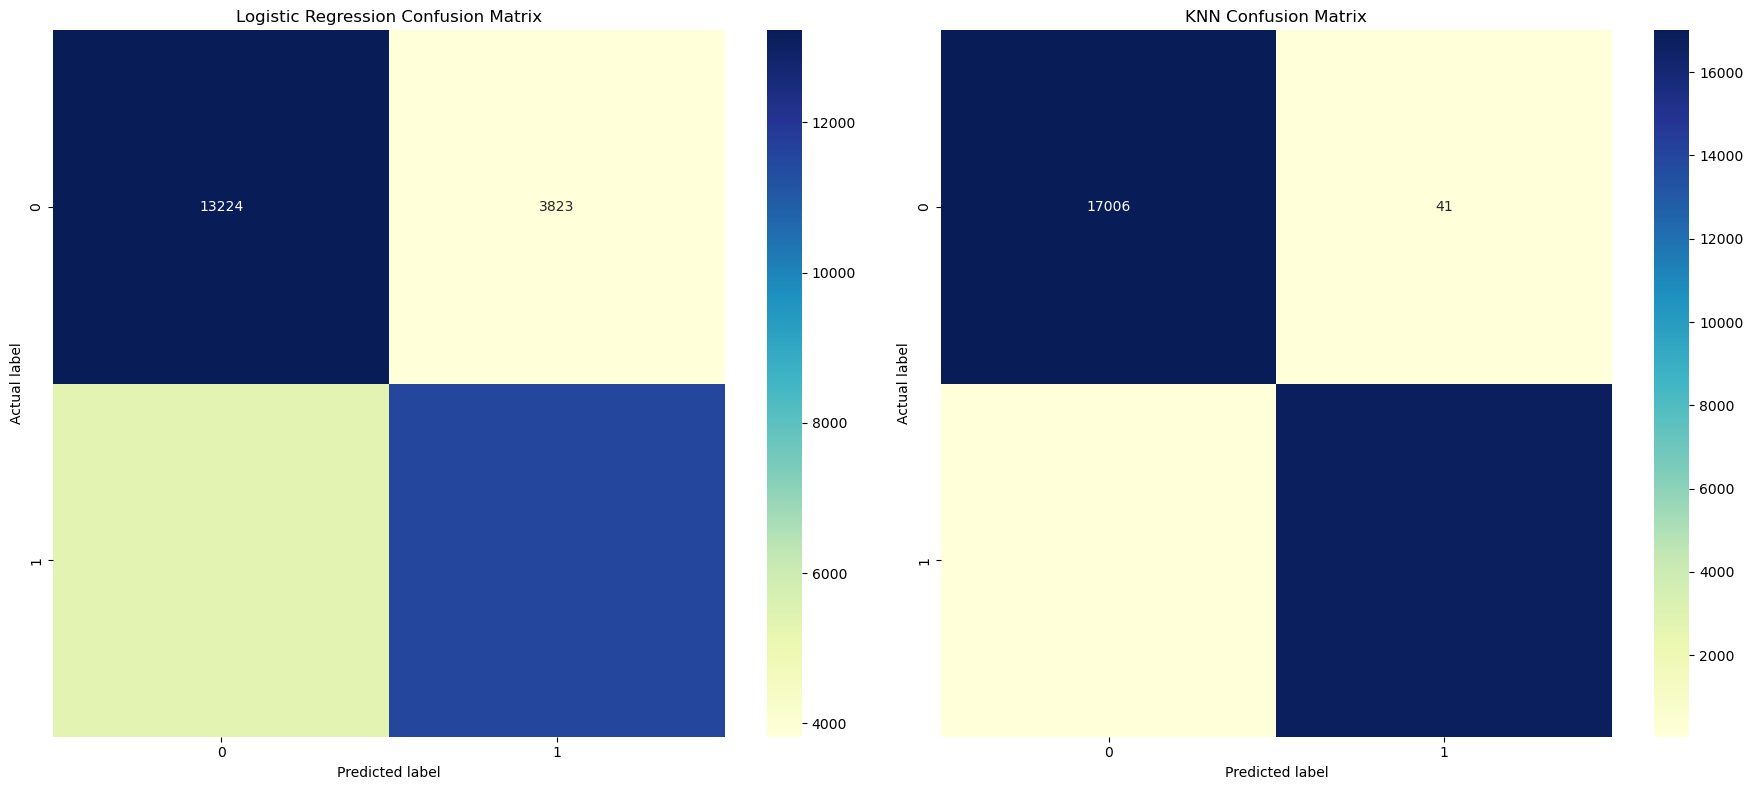

In [814]:
cnf_matrix_lr = metrics.confusion_matrix(y_test, log_reg.predict(X_test))
cnf_matrix_knn = metrics.confusion_matrix(y_test, knn.predict(X_test))

fig, ax = plt.subplots(1, 2, figsize=(18, 8))

sns.heatmap(pd.DataFrame(cnf_matrix_lr), annot=True, cmap="YlGnBu", fmt='g', ax=ax[0])
ax[0].set_title('Logistic Regression Confusion Matrix')
ax[0].set_xlabel('Predicted label')
ax[0].set_ylabel('Actual label')

sns.heatmap(pd.DataFrame(cnf_matrix_knn), annot=True, cmap="YlGnBu", fmt='g', ax=ax[1])
ax[1].set_title('KNN Confusion Matrix')
ax[1].set_xlabel('Predicted label')
ax[1].set_ylabel('Actual label')

plt.tight_layout()
plt.show()

In [815]:
TN = cnf_matrix_lr[0][0]
FN = cnf_matrix_lr[1][0]
TP = cnf_matrix_lr[1][1]
FP = cnf_matrix_lr[0][1]

print(metrics.classification_report(y_test, log_reg.predict(X_test)))
print()
print(f"The logistic regression model predicted {TN} edible mushrooms and {FN} poisonus mushrooms as edible.")
print(f"The logistic regression model predicted {TP} poisonous mushrooms and {FP} edible mushrooms as poisonous.")

              precision    recall  f1-score   support

           0       0.71      0.78      0.74     17047
           1       0.75      0.68      0.72     16841

    accuracy                           0.73     33888
   macro avg       0.73      0.73      0.73     33888
weighted avg       0.73      0.73      0.73     33888


The logistic regression model predicted 13224 edible mushrooms and 5310 poisonus mushrooms as edible.
The logistic regression model predicted 11531 poisonous mushrooms and 3823 edible mushrooms as poisonous.


In [816]:
TN = cnf_matrix_knn[0][0]
FN = cnf_matrix_knn[1][0]
TP = cnf_matrix_knn[1][1]
FP = cnf_matrix_knn[0][1]

print(metrics.classification_report(y_test, knn.predict(X_test)))
print()
print(f"The KNN classification model predicted {TN} edible mushrooms and {FN} poisonus mushrooms as edible.")
print(f"The KNN classification model predicted {TP} poisonous mushrooms and {FP} edible mushrooms as poisonous.")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17047
           1       1.00      1.00      1.00     16841

    accuracy                           1.00     33888
   macro avg       1.00      1.00      1.00     33888
weighted avg       1.00      1.00      1.00     33888


The KNN classification model predicted 17006 edible mushrooms and 65 poisonus mushrooms as edible.
The KNN classification model predicted 16776 poisonous mushrooms and 41 edible mushrooms as poisonous.


### Conclusion

From the classification reports and confusion matrices, we can conclude that the best model for classifying edible and poisonous mushrooms is the KNN classification model with k = 1, which produces an accuracy of **0.9969**. We are able to use this model for new mushroom data to classify each mushroom as edible or poisonous based on the given features, which we chose were observable and/or measurable. 

Now, we can use a correlation matrix to see which other features are highly correlated.

## **Correlation Matrix**

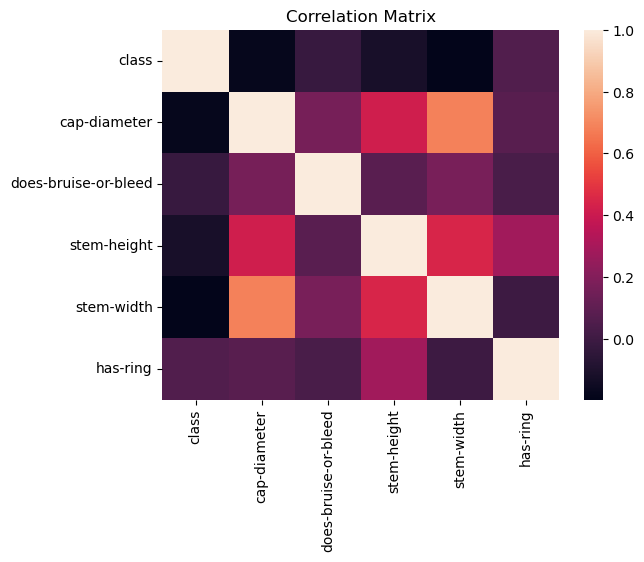

In [817]:
corr_labels = ["class", "cap-diameter", "does-bruise-or-bleed", "stem-height", "stem-width", "has-ring"]
corr = df[corr_labels].corr()

sns.heatmap(corr, annot=False)
plt.title("Correlation Matrix")
plt.show()

We can see that there is a noticable correlation between stem height, stem width, and cap diameter. We can explore this further with some regression models.

## **Regression Models**

### Data Preprocessing

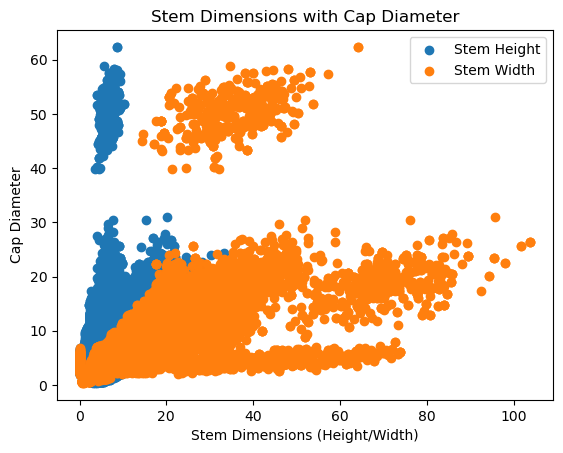

In [818]:
features = ["cap-diameter", "stem-height", "stem-width"]

fig = plt.figure()

plt.scatter(df["stem-height"], df["cap-diameter"], label='Stem Height')
plt.scatter(df["stem-width"], df["cap-diameter"], label='Stem Width')
plt.title('Stem Dimensions with Cap Diameter')
plt.xlabel('Stem Dimensions (Height/Width)')
plt.ylabel('Cap Diameter')
plt.legend()
plt.show()

There seems to be a clear divide between cap diameters. This could be a result of a different species or type of mushroom in the dataset. For simplicity, we will just emit this data when training the model since we are not losing significant amount of data points.

In [819]:
df_no_outliers = df[df["cap-diameter"] < 35]

### Data Scaling

From the graph of unscaled mushroom dimensions, we can see that the data seems to be skewed similarly to a pareto distribution. Therefore, to minimize the effect of outliers in our data while scaling, we will use robust scaling.

C:\Users\cryst\AppData\Local\Temp\ipykernel_1992\2997960766.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_outliers[features] = scaler.fit_transform(df_no_outliers[features])


Text(0.5, 1.0, 'Robust Scaled Mushroom Dimensions')

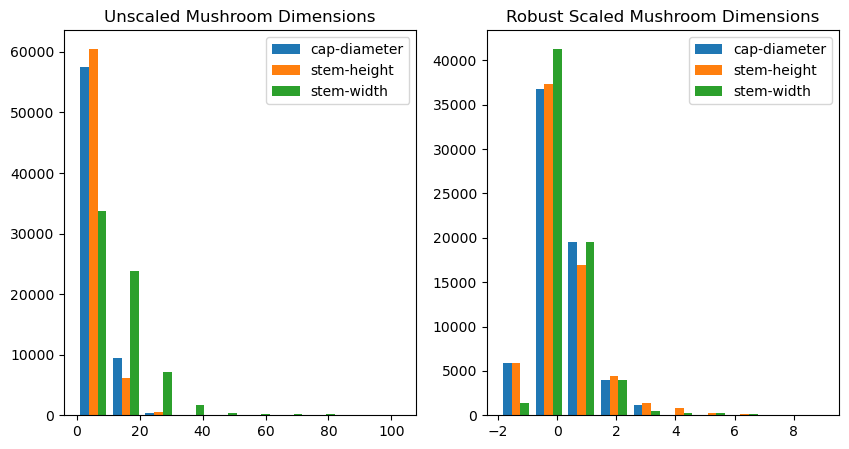

In [820]:
fig,ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].hist(df_no_outliers[features], label=features)
ax[0].legend()
ax[0].set_title("Unscaled Mushroom Dimensions")

scaler = RobustScaler()
df_no_outliers[features] = scaler.fit_transform(df_no_outliers[features])

ax[1].hist(df_no_outliers[features], label=features)
ax[1].legend()
ax[1].set_title("Robust Scaled Mushroom Dimensions")

### Training and Testing Sets

In [821]:
features = ["stem-height", "stem-width"]
target = "cap-diameter"

X = df_no_outliers[features]
y = df_no_outliers[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=True, random_state=0)

### Linear Regression Model

In [822]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

kf = KFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(lin_reg, X, y, cv=kf, scoring="r2")

print(f"R2 score for linear regression:")
print(f"-train score: {lin_reg.score(X_train, y_train):.4f} \n-test score: {lin_reg.score(X_test, y_test):.4f}")

R2 score for linear regression:
-train score: 0.6297 
-test score: 0.6446


### KNN Regression Model

In [823]:
knn = KNeighborsRegressor(n_neighbors=30)
knn.fit(X_train, y_train)

print(f"R2 score for KNN regression:")
print(f"-train score: {knn.score(X_train, y_train):.4f} \n-test score: {knn.score(X_test, y_test):.4f}")

R2 score for KNN regression:
-train score: 0.7979 
-test score: 0.7849


### Comparison

c:\Users\cryst\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


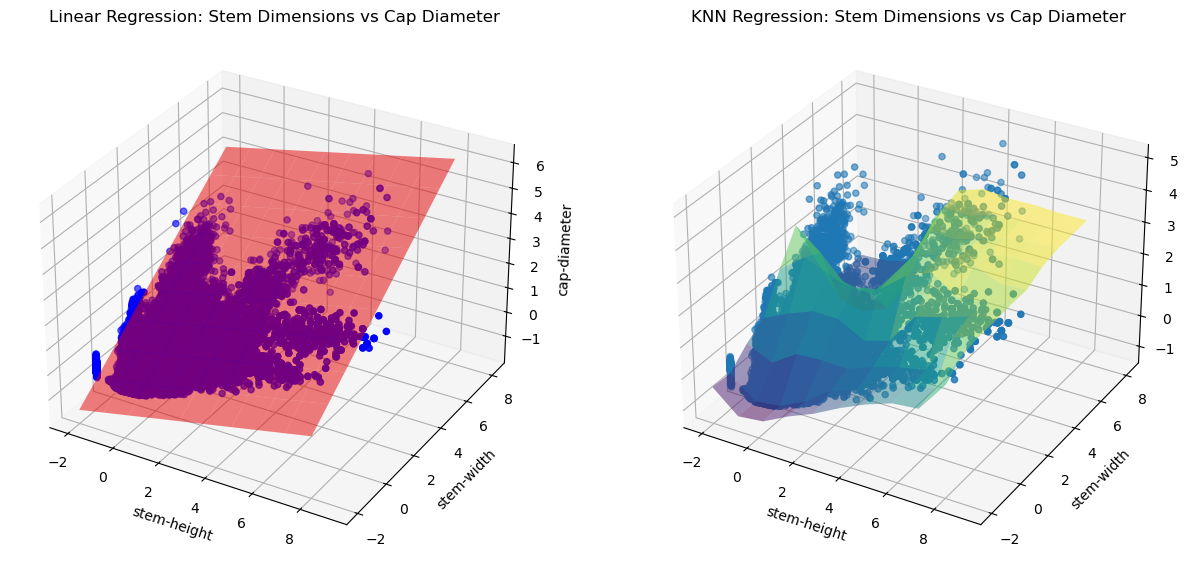

In [824]:
fig = plt.figure(figsize=(15, 30))

xx, yy = np.meshgrid(np.linspace(-2, 8, 10), np.linspace(-2, 8, 10))

ax = fig.add_subplot(1,2,1, projection='3d')
ax.scatter(df_no_outliers[features[0]], df_no_outliers[features[1]], y, color='b', label='Data Points')

coefficients = lin_reg.coef_
intercept = lin_reg.intercept_
zz = coefficients[0] * xx + coefficients[1] * yy + intercept

ax.plot_surface(xx, yy, zz, alpha=0.5, color='r', label='Regression Plane')

ax.set_xlabel(f'{features[0]}')
ax.set_ylabel(f'{features[1]}')
ax.set_zlabel(target)
ax.set_title('Linear Regression: Stem Dimensions vs Cap Diameter')

ax = fig.add_subplot(1,2,2, projection='3d')
ax.scatter(df_no_outliers[features[0]], df_no_outliers[features[1]], y, label='Data Points')

Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

ax.plot_surface(xx, yy, Z, alpha=0.5, cmap='viridis')

ax.set_xlabel(f'{features[0]}')
ax.set_ylabel(f'{features[1]}')
ax.set_zlabel(target)
ax.set_title('KNN Regression: Stem Dimensions vs Cap Diameter')

plt.show()

### Conclusion

We conclude that the KNN regression model with k = 30 produces an $R^2$ score of **0.7849** and is the best predictor of mushroom cap diameter given stem height and width. However, it is not the greatest model. The reason for this may be because of the different species of mushrooms that are undefined in this certain dataset. Therefore, we can only say that there is a slight correlation between mushroom cap diameter and stem dimensions, and the ratio may depend on the species of mushrooms or other factors.

## **References**

[Mushroom Dataset From Kaggle](https://www.kaggle.com/datasets/vishalpnaik/mushroom-classification-edible-or-poisonous/data)

[Linear Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression)

[Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

[Nearest Neighbors Classification and Regression](https://scikit-learn.org/stable/modules/neighbors.html)

[Robust Scaling](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html)


A special thanks to StackOverflow and [Math 10 Notes](https://rayzhangzirui.github.io/math10sp24/intro.html).